In [86]:
import numpy as np
import torch
import random
import matplotlib.pyplot as plt
from collections import namedtuple, defaultdict, deque
import math
import torch.nn as nn
import torch.optim as optim


Point = namedtuple('Point', ['x', 'y'])
def distance(p1: Point, p2: Point):
    return (p1[0] - p2[0])**2 + (p1[1] - p2[1])**2

class IsoscelesTriangle:
    # m is number of rows, and n is number of columns. The x coordinate is 0 - n-1, and y coordinate is 0 - m-1
    def __init__(self, m:int, n:int):
        self.grid_size = (m,n)
        self.action_space = [Point(x,y) for x in range(n) for y in range(m)]
        self.points = []
        self.distance_map = {}

    def add_point(self, point: Point):
        '''
        :param point:
        :return: True/False: either find an isosceles triangle, and the game stops
                 tuple of 3 points/None: the isosceles_triangle found, or else None
                 the updated state of the game, represented as a list of points
                 the reward
        '''
        # Check if the input is valid
        if not self._valid_action(point):
            # print(f"Invalid Point {point[0]}, {point[1]} Added")
            return True, None, self.points, -10

        self.distance_map[point] = defaultdict(list)
        for p in self.points:
            d = distance(point, p)
            self.distance_map[p][d].append(point)
            self.distance_map[point][d].append(p)
            if len(self.distance_map[point][d]) >= 2:
                return True, (point, p, self.distance_map[point][d][0]), self.points, 0
            if len(self.distance_map[p][d]) >= 2:
                return True, (point, p, self.distance_map[p][d][0]), self.points, 0

        self.action_space.remove(point)
        self.points.append(point)
        return False, None, self.points, 1

    def _valid_action(self, point: Point):
        if point not in self.points and 0 <= point[0] < self.grid_size[1] and 0 <= point[1] < self.grid_size[0]:
            return True
        return False

    def decode_action(self, action: int):
        m,n = self.grid_size
        x,y= divmod(action,m)
        return Point(x,y)

    def encode_action(self, point: Point):
        m,n = self.grid_size
        return point[0] * m + point[1]

    # this will return a list of points that we can add
    def get_action_space(self):
        return self.action_space

    # each point can exist or not exist.
    def get_state_space_size(self):
        return self.grid_size[0] * self.grid_size[1]

    def reset(self):
        # This will reset the game, and return the current states
        del self.points
        del self.distance_map
        del self.action_space
        self.points = []
        self.distance_map = {}
        self.action_space = [Point(x,y) for x in range(self.grid_size[1]) for y in range(self.grid_size[0])]
        return self.points

    def encode_state(self, points):
        """
        Encodes the selected points into a binary vector of length grid_size * grid_size
        """
        m,n = self.grid_size
        state = torch.zeros(m * n, dtype=torch.float32)
        for x, y in points:
            index = x * m + y  # row-major order
            state[index] = 1.0
        return state

class StrictIsoscelesTriangle(IsoscelesTriangle):
    def add_point(self, point: Point):
        if not self._valid_action(point):
            # print(f"Invalid Point {point[0]}, {point[1]} Added")
            return True, None, self.points, -10

        self.distance_map[point] = defaultdict(list)
        for p in self.points:
            d = distance(point, p)
            self.distance_map[p][d].append(point)
            self.distance_map[point][d].append(p)
            if len(self.distance_map[point][d]) >= 3:
                return True, (point, p, self.distance_map[point][d][0]), self.points, 0
            if len(self.distance_map[p][d]) >= 3:
                return True, (point, p, self.distance_map[p][d][0]), self.points, 0
            if len(self.distance_map[p][d]) == 2:
                p1 = self.distance_map[p][d][0]
                # p is the point in the middle
                slope1 = p[1] - p1[1]
                slope2 = point[1] - p[1]
                # In this case, the 3 points is not on the same line, this forms a triangle
                if slope1 != slope2:
                    return True, (point, p, p1), self.points, 0
            if len(self.distance_map[point][d]) == 2:
                p1 = self.distance_map[point][d][0]
                # point is the point in the middle
                slope1 = point[1] - p1[1]
                slope2 = p[1] - point[1]
                if slope1 != slope2:
                    return True, (point, p, p1), self.points, 0

        self.action_space.remove(point)
        self.points.append(point)
        return False, None, self.points, 1


# Define the neural network for Q-learning
class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )

    def forward(self, x):
        return self.fc(x)

# Hyperparameters for models
gamma = 1
epsilon = 0.1
lr = 1e-4
batch_size = 64
target_update_freq = 10
memory_size = 10000
episodes = 50000


/var/folders/2h/69hg_xrd4fb4nytgmwvn8ch40000gn/T/ipykernel_30136/356339488.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32)


at episode 0, total reward 2 with fulllist of points: [Point(x=0, y=2), Point(x=13, y=1)]
at episode 500, total reward 8 with fulllist of points: [Point(x=13, y=1), Point(x=9, y=0), Point(x=2, y=0), Point(x=14, y=0), Point(x=9, y=1), Point(x=11, y=1), Point(x=6, y=2), Point(x=5, y=2)]
at episode 1000, total reward 10 with fulllist of points: [Point(x=6, y=0), Point(x=0, y=2), Point(x=3, y=2), Point(x=9, y=1), Point(x=14, y=1), Point(x=6, y=1), Point(x=8, y=1), Point(x=14, y=2), Point(x=10, y=1), Point(x=1, y=0)]
at episode 1500, total reward 7 with fulllist of points: [Point(x=13, y=1), Point(x=5, y=0), Point(x=9, y=0), Point(x=6, y=0), Point(x=12, y=1), Point(x=2, y=0), Point(x=0, y=2)]
at episode 2000, total reward 11 with fulllist of points: [Point(x=13, y=1), Point(x=0, y=0), Point(x=8, y=2), Point(x=5, y=2), Point(x=0, y=2), Point(x=3, y=2), Point(x=11, y=0), Point(x=14, y=0), Point(x=1, y=2), Point(x=12, y=1), Point(x=8, y=0)]
at episode 2500, total reward 8 with fulllist of poin

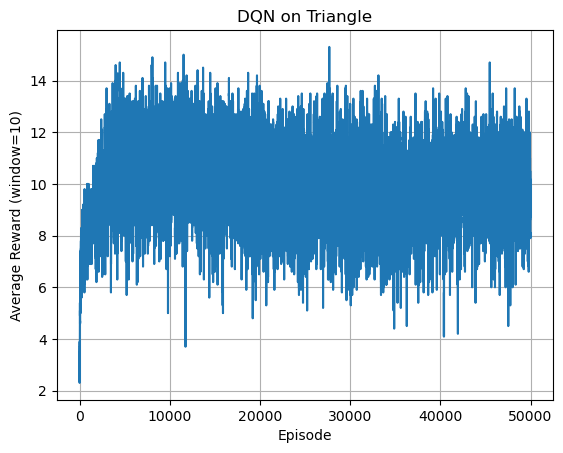

In [92]:
# m is number of rows, and n is number of cols
m = 3
n = 15
env = StrictIsoscelesTriangle(m, n)
input_dim = m * n
output_dim = m * n

# new_training = True


policy_net = DQN(input_dim, output_dim)
target_net = DQN(input_dim, output_dim)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.Adam(policy_net.parameters(), lr=lr)
memory = deque(maxlen=memory_size)

episode_rewards = []

# Main training loop
for episode in range(episodes):
    state = env.encode_state(env.reset())
    total_reward = 0
    done = False

    # epsilon greedy algorithm
    while not done:
        state_tensor = torch.tensor(state, dtype=torch.float32)
        if random.random() < epsilon:
            action = random.sample(env.action_space, 1)[0]
        else:
            with torch.no_grad():
                action = policy_net(state_tensor).argmax().item()
                action = env.decode_action(action)

        terminated, result_found, next_state_raw, reward = env.add_point(action)
        action = env.encode_action(action)
        next_state = env.encode_state(next_state_raw)
        done = terminated

        if not done:
            total_reward += reward

        memory.append((state, action, reward, next_state, done))
        state = next_state


        # Training step
        # If we get enough data sampled from the action of gradient, then we train our network
        if len(memory) >= batch_size:
            batch = random.sample(memory, batch_size)
            states, actions, rewards, next_states, dones = zip(*batch)

            # states = torch.tensor(states, dtype=torch.float32)
            states = torch.stack(states).float()
            actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1)
            rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1)
            # next_states = torch.tensor(next_states, dtype=torch.float32)
            next_states = torch.stack(next_states).float()
            dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1)

            q_values = policy_net(states).gather(1, actions)
            next_q_values = target_net(next_states).max(1, keepdim=True)[0]
            targets = rewards + gamma * next_q_values * (1 - dones)

            loss = nn.functional.mse_loss(q_values, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    episode_rewards.append(total_reward)

    # Update target network
    if episode % target_update_freq == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if episode % 500 == 0:
        print(f"at episode {episode}, total reward {total_reward} with fulllist of points: {next_state_raw}")

# env.close()

plt.plot(np.convolve(episode_rewards, np.ones(10)/10, mode='valid'))
plt.xlabel("Episode")
plt.ylabel("Average Reward (window=10)")
plt.title("DQN on Triangle")
plt.grid(True)
plt.show()



In [94]:
max(episode_rewards)

16

In [96]:
state = env.encode_state(env.reset())
total_reward = 0
done = False

while not done:
    state_tensor = torch.tensor(state, dtype=torch.float32)
    with torch.no_grad():
        action = policy_net(state_tensor).argmax().item()
        action = env.decode_action(action)

    terminated, result_found, next_state_raw, reward = env.add_point(action)
    action = env.encode_action(action)
    next_state = env.encode_state(next_state_raw)
    done = terminated

    state = next_state
    total_reward += reward

print(total_reward)
print("points", next_state_raw)

10
points [Point(x=12, y=2), Point(x=10, y=2), Point(x=5, y=0), Point(x=13, y=2), Point(x=6, y=2), Point(x=14, y=2), Point(x=3, y=0), Point(x=0, y=1), Point(x=7, y=2), Point(x=1, y=2)]


/var/folders/2h/69hg_xrd4fb4nytgmwvn8ch40000gn/T/ipykernel_30136/230526867.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  state_tensor = torch.tensor(state, dtype=torch.float32)


# TODO,
The issue is that the AI view 3 points in a row as an isosceles triangle